In [30]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr


In [72]:
BASE_URL = 'https://mdl1.marine.copernicus.eu/data/BLKSEA_ANALYSISFORECAST_PHY_007_001/bs-cmcc-cur-an-fc-d'
TIME_CHUNKED = f'{BASE_URL}/timeChunked.zarr'
GEO_CHUNKED = f'{BASE_URL}/geoChunked.zarr'

## Rendering maps

If we are rendering maps, we want to access the **time-chunked CMS dataset**. This way we will only be fetching the data we need.

In [90]:
ds_time = xr.open_zarr(TIME_CHUNKED)
ds_time

,Array,Chunk
Bytes,51.52 GiB,2.35 MiB
Shape,"(741, 121, 261, 591)","(2, 2, 261, 591)"
Count,22632 Tasks,22631 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,51.52 GiB,2.35 MiB
Shape,"(741, 121, 261, 591)","(2, 2, 261, 591)"
Count,22632 Tasks,22631 Chunks
Type,float32,numpy.ndarray


Let's say we want to plot **water velocity E/N (zonal/meridional) components** at the surface of the Black Sea for July 1st, 2022:

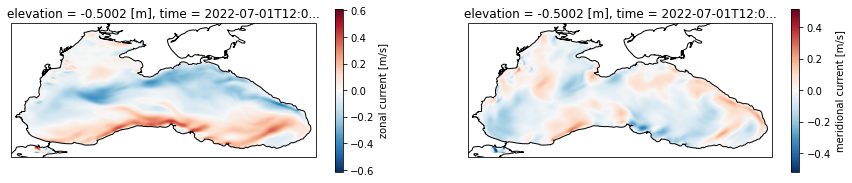

In [91]:
# Define the data we need (note that this line fetches _no data_!)
ds_subset = ds_time.sel(time="2022-07-01", elevation=0, method="nearest")

# Plot it -- the plot() calls will cause data to be fetched
fig = plt.figure(figsize=(15, 3))
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree())
ds_subset.uo.plot()
ax.coastlines()

ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree())
ds_subset.vo.plot()
ax.coastlines()


Let's plot now **water velocity** (magnitude) for the same date:

Text(0.5, 1.0, 'Water velocity\nelevation = -0.5002, time = 2022-07-01T12:00:00')

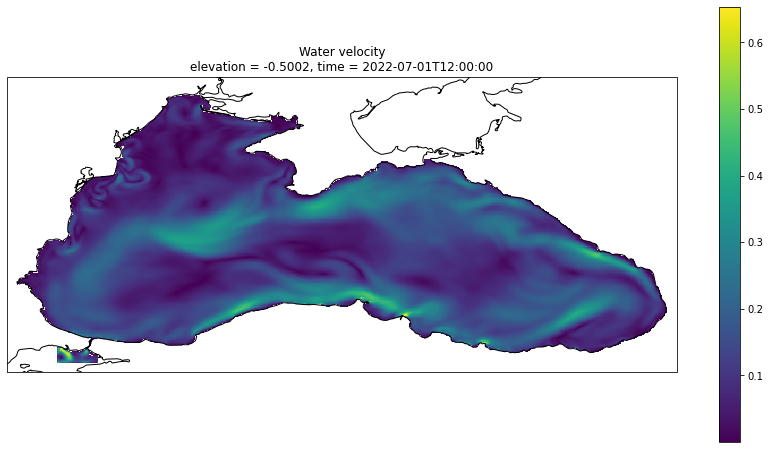

In [79]:
# Define how the magnitude should be calculated (again, this fetches _no data_ at all!)
magnitude = lambda x, y: np.sqrt(x**2 + y**2)
water_velocity = xr.apply_ufunc(magnitude, ds_subset.uo, ds_subset.vo, dask='allowed')

# Plot it -- the plot() call will cause data to be fetched and the norm to be calculated
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
water_velocity.plot()
ax.coastlines()
ax.set_title(f"Water velocity\n{ax.get_title()}")

Now, what about **direction**?

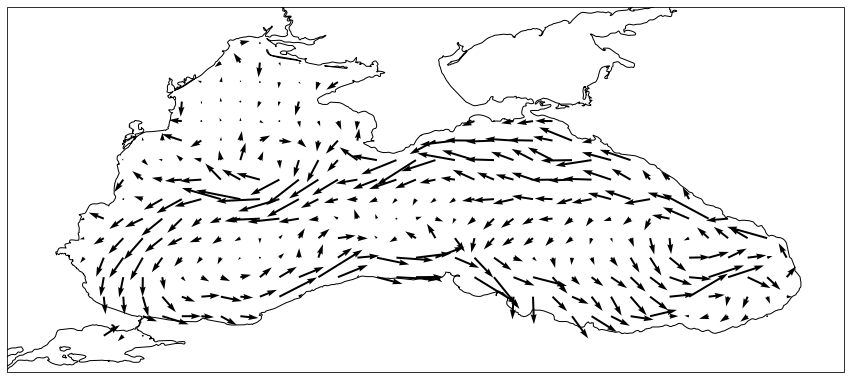

In [77]:
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
step = 15
ax.quiver(ds_subset.longitude[::step], ds_subset.latitude[::step], ds_subset.uo[::step, ::step], ds_subset.vo[::step, ::step])
ax.coastlines()

## Plotting time series

For time series, we are going to access the **geo-chunked CMS dataset**. This will optimise data fetching, downloading only the data for the region we need.

In [92]:
ds_geo = xr.open_zarr(GEO_CHUNKED)
ds_geo

,Array,Chunk
Bytes,51.52 GiB,1.42 MiB
Shape,"(741, 121, 261, 591)","(727, 1, 16, 32)"
Count,78167 Tasks,78166 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,51.52 GiB,1.42 MiB
Shape,"(741, 121, 261, 591)","(727, 1, 16, 32)"
Count,78167 Tasks,78166 Chunks
Type,float32,numpy.ndarray


Let's compare two time series of **Eastward water velocity**: one close to the Northern limit of the Black Sea, and one closer to the South. Water moves in this region counter-clockwise, so we expect to see different signs in the time series.

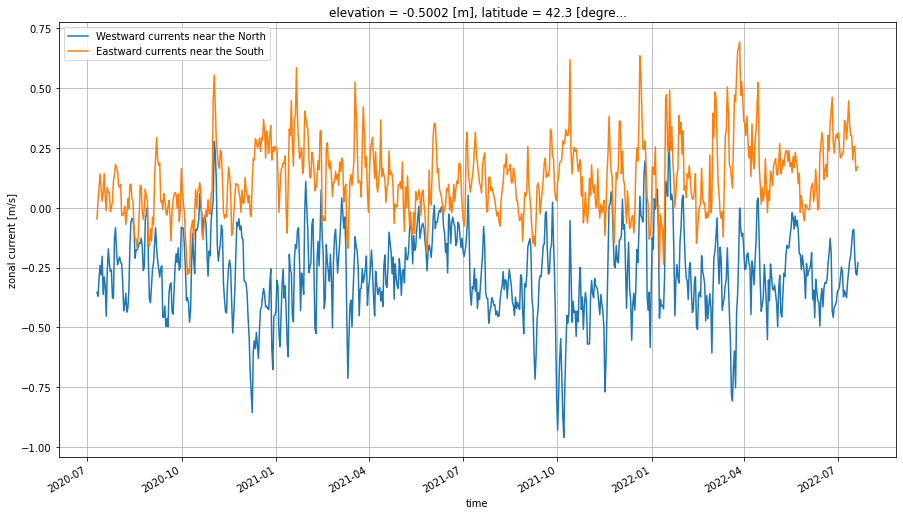

In [93]:
# Define two subsets (_no data_ is fetched yet)
ds1 = ds_geo.sel(longitude=34.032358, latitude=44.201940, elevation=0, method="nearest")
ds2 = ds_geo.sel(longitude=34.032358, latitude=42.297671, elevation=0, method="nearest")

# Plot them
plt.figure(figsize=(15, 8))
ds1.uo.plot()
ds2.uo.plot()
plt.legend(["Westward currents near the North", "Eastward currents near the South"])
plt.grid()

# Takeaways

In the above examples, we've seen how to obtain fast maps and time series from a Copernicus Marine dataset in ARCO format (Zarr datacube). In each case, we've used the dataset with the chunking that best adapted to our needs, so xarray only fetched the minimum data that was required for our use case.

We've barely scratched the surface of what's possible with ARCO datasets. If you want to learn more, you may want to try out:

* Getting an average time series for a given area.
* Calculating the difference between two snapshots.

